In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [12]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Read experiments data

In [3]:
# Linux experiments
results_path = Path("experiment_results/")

In [4]:
results = []
for path in results_path.glob("normal_run*.txt"):
    with path.open() as fp:
        for line in fp:
            results.append(json.loads(line))

In [6]:
linux_df = pd.DataFrame(results).rename(columns={"command": "subcommand", "time": "seconds"})
linux_df['platform'] = 'Linux'
linux_df.head()

,subcommand,num_threads,num_elements,num_iterations,collection,seconds,gil,platform
0,create_elements,1,1000000,1000,list,0.145741,0,Linux
1,create_elements,1,1000000,1000,list,0.136849,0,Linux
2,create_elements,1,1000000,1000,list,0.135710,0,Linux
3,create_elements,1,1000000,1000,list,0.134515,0,Linux
4,create_elements,1,1000000,1000,list,0.139405,0,Linux


In [7]:
mac_df = pd.read_json('experiment_results/mac_run.json').rename(columns={'time': 'seconds'})
mac_df['platform'] = 'MacOS'
mac_df.head()

,gil,collection,num_threads,num_iterations,subcommand,run,seconds,platform
0,0,list,1,1000,create_elements,0,0.199232,MacOS
1,0,list,1,1000,create_elements,1,0.202870,MacOS
2,0,list,1,1000,create_elements,2,0.201585,MacOS
3,0,list,1,1000,create_elements,3,0.204321,MacOS
4,0,list,1,1000,create_elements,4,0.201249,MacOS


In [8]:
columns = ['subcommand', 'gil', 'collection', 'num_threads', 'seconds', 'platform']

In [10]:
df = pd.concat([linux_df[columns], mac_df[columns]])
df.head()

,subcommand,gil,collection,num_threads,seconds,platform
0,create_elements,0,list,1,0.145741,Linux
1,create_elements,0,list,1,0.136849,Linux
2,create_elements,0,list,1,0.135710,Linux
3,create_elements,0,list,1,0.134515,Linux
4,create_elements,0,list,1,0.139405,Linux


In [59]:
slowdown_df = df.groupby(['platform', 'subcommand', 'collection', 'gil', 'num_threads'])['seconds'].mean().reset_index()
slowdown_df = slowdown_df.groupby(['platform', 'subcommand', 'collection', 'num_threads']).apply(lambda rows: rows.groupby('gil')['seconds'].first().sort_index(ascending=False).pct_change().dropna().iloc[0]).to_frame().reset_index().rename(columns={0: 'Slowdown'}).rename(columns={'subcommand': 'Benchmark', 'collection': 'Collection'})

slowdown_df['Performance Difference'] = slowdown_df['Slowdown'] * -1
del slowdown_df['Slowdown']
slowdown_df.head()

,platform,Benchmark,Collection,num_threads,Performance Difference
0,Linux,check_length,dict,1,0.021444
1,Linux,check_length,dict,10,0.112881
2,Linux,check_length,dict,100,0.420391
3,Linux,check_length,list,1,-0.075518
4,Linux,check_length,list,10,0.125006


### Overview of benchmarks per collection

#### Linux

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


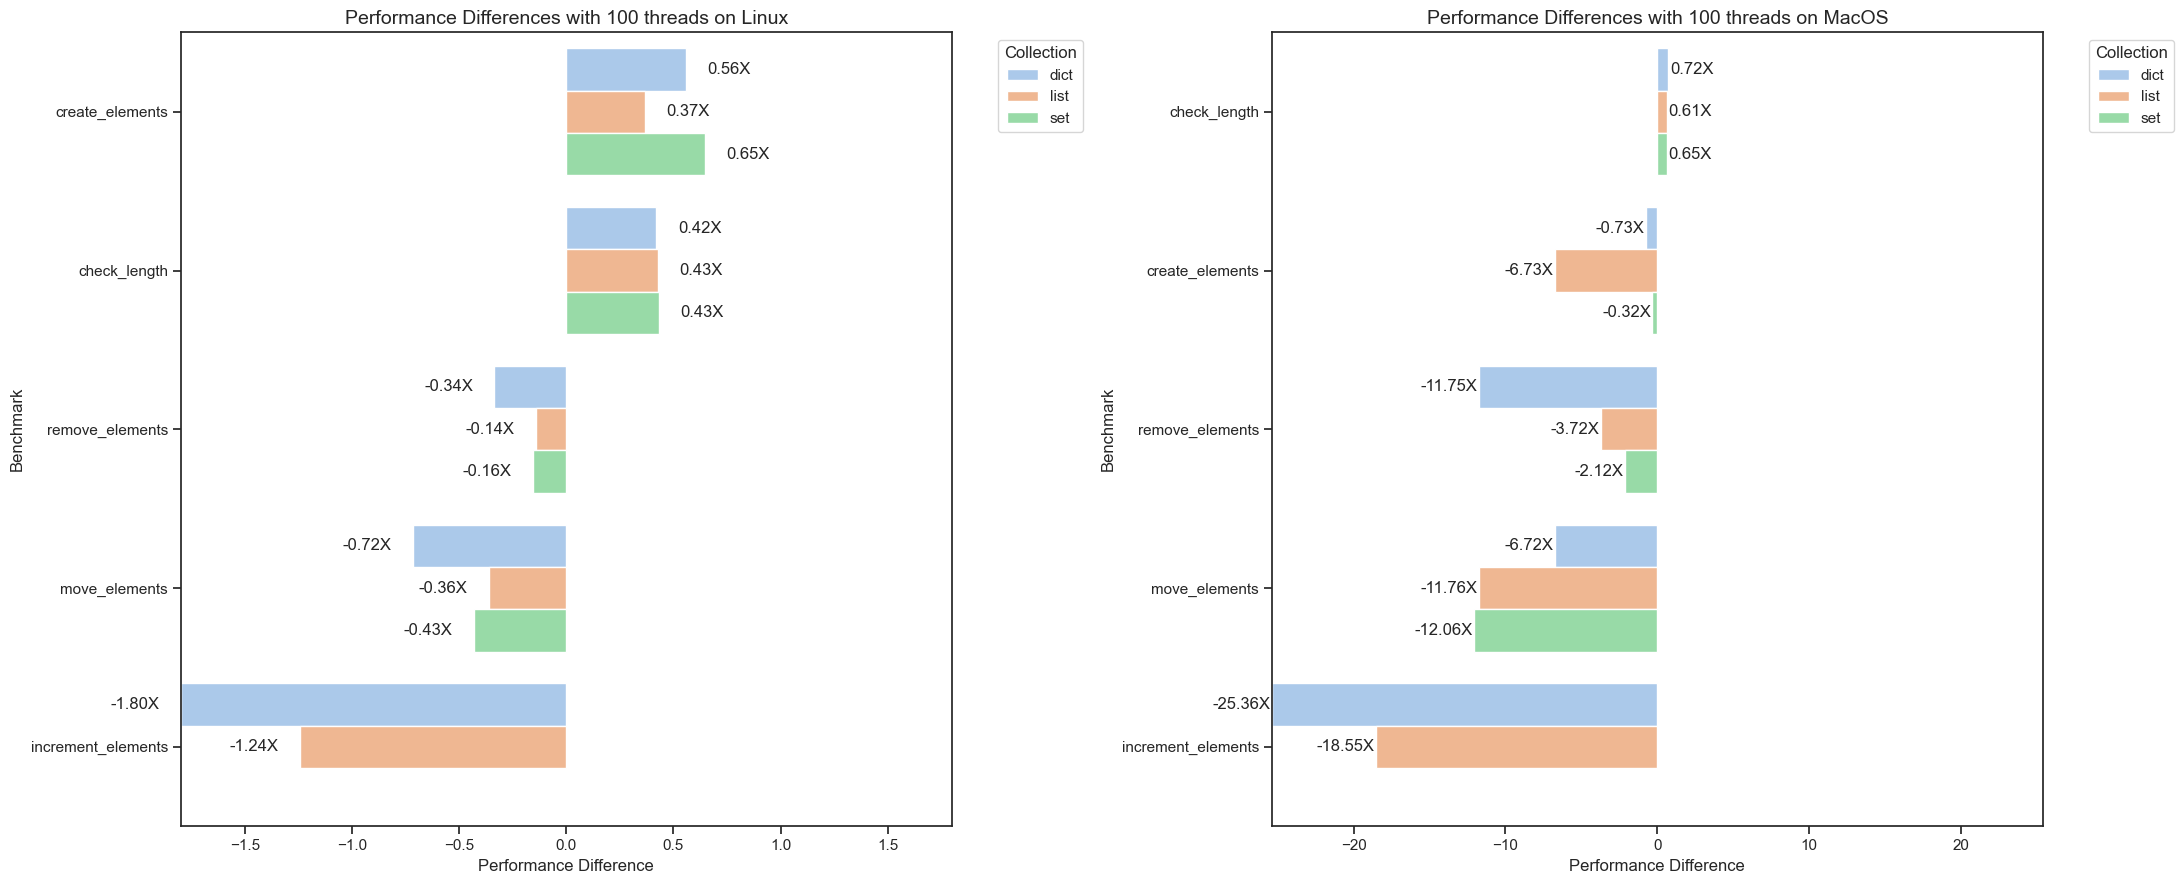

In [61]:
def plot_slowdown(bench_df, figure, axis):
    platform = bench_df['platform'].unique()[0]
    num_threads = bench_df['num_threads'].unique()[0]

    bench_df = bench_df.set_index('Benchmark').loc[bench_df.groupby('Benchmark')['Performance Difference'].mean().sort_values(ascending=False).index].reset_index()
    
    # Create the diverging bar chart
    sns.barplot(
        data=bench_df,
        x='Performance Difference',
        y='Benchmark',
        hue='Collection',
        orient='h',
        ax=axis
    )
    
    # Calculate the symmetric range around zero
    abs_max = max(abs(bench_df['Performance Difference'].min()), bench_df['Performance Difference'].max())
    axis.set_xlim(-abs_max, abs_max)
    
    for bar in axis.patches:
        value = bar.get_width()
        position = bar.get_y() + bar.get_height() / 2
    
        axis.text(
            value + (0.1 if value > 0 else -0.1),  # Adjust text position slightly outside the bar
            position,
            f"{value:.2f}X",
            va='center',
            ha='left' if value > 0 else 'right'
        )
    # Labeling and title
    
    axis.set_title(f"Performance Differences with {num_threads} threads on {platform}", fontsize=14)
    axis.set_xlabel("Performance Difference")
    axis.set_ylabel("Benchmark")
    
    # Adjust legend
    axis.legend(title="Collection", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    sns.despine(ax=ax, trim=True, offset=10, left=True)


fig, axes = plt.subplots(1, 2, figsize=(22, 9))

plot_slowdown(slowdown_df.query("platform == 'Linux' and Benchmark != 'increment_integer' and num_threads == 100").copy(), fig, axes[0])
plot_slowdown(slowdown_df.query("platform == 'MacOS' and Benchmark != 'increment_integer' and num_threads == 100").copy(), fig, axes[1])
fig.tight_layout()

### Linux

All the following benchmarks are based on Linux

In [55]:
linux_slowdown_df = slowdown_df.query("platform == 'Linux'").copy()

### Slowdown GIL vs Free-threaded

The "Increment Elements" benchmark is the one with the worst performance, how this changes from 1 to 100 threads?

Text(0.5, 1.0, 'Performance penalty of `increment_elements` benchmark on Linux')

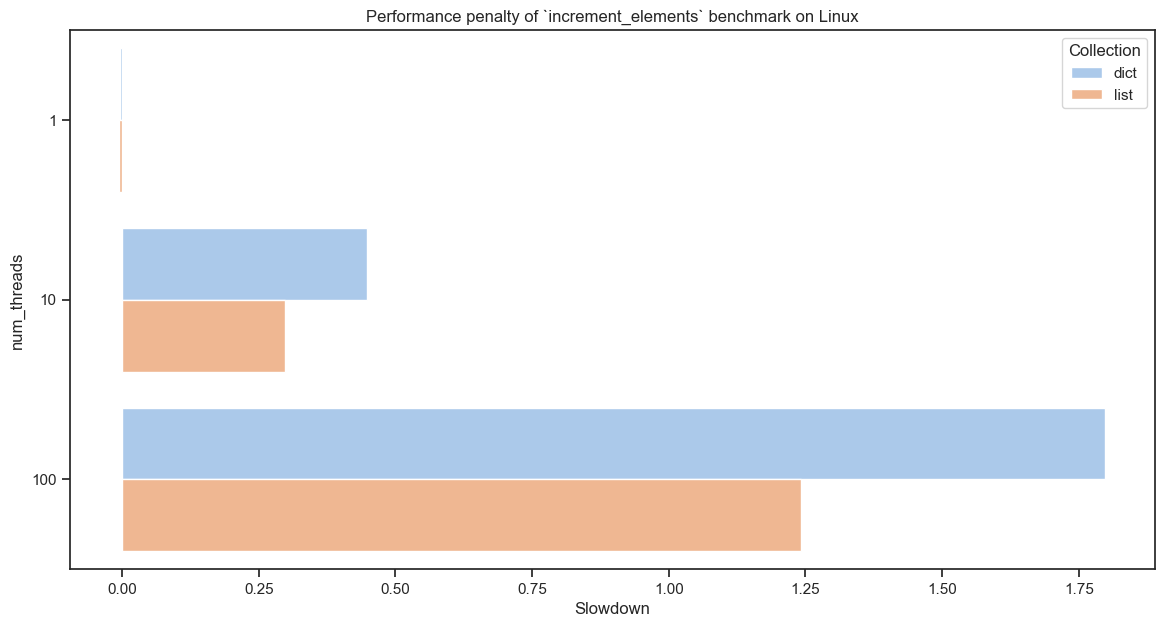

In [56]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(
    data=linux_slowdown_df.query('Benchmark == "increment_elements"'),
    y='num_threads',
    x='Slowdown',
    hue='Collection',
    orient='h',
    ax=ax
)
ax.set_title("Performance penalty of `increment_elements` benchmark on Linux")

### Worst performers per Benchmark (100 threads)

In [19]:
subdf = linux_slowdown_df.query("num_threads == 100").groupby(['Benchmark', 'Collection'])['Slowdown'].max().reset_index()
subdf = subdf.loc[subdf.groupby('Benchmark')['Slowdown'].nlargest(1, keep='first').reset_index().query("Slowdown > 0")['level_1'].values].sort_values(by='Slowdown')
subdf['Worst Performers'] = subdf['Benchmark'] + ' - ' + subdf['Collection']
subdf

,Benchmark,Collection,Slowdown,Worst Performers
12,remove_elements,dict,0.335709,remove_elements - dict
9,move_elements,dict,0.716400,move_elements - dict
6,increment_elements,dict,1.798400,increment_elements - dict


Text(0.5, 1.0, 'Worst performers (100 threads)')

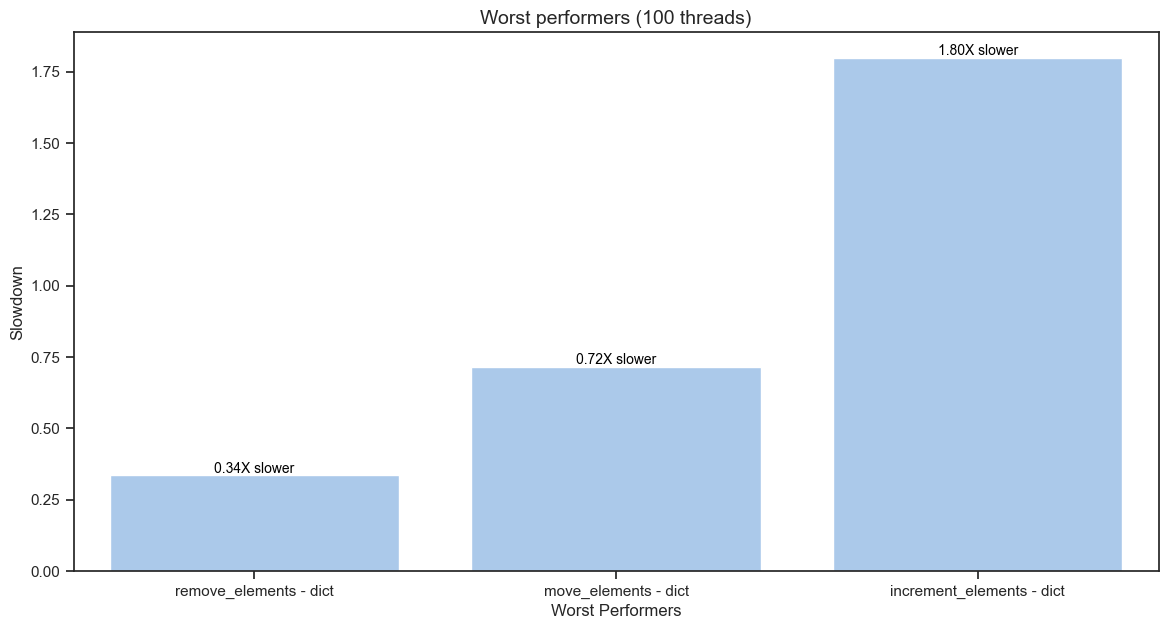

In [20]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(data=subdf, x='Worst Performers', y='Slowdown', palette=["b"], ax=ax)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}X slower', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

ax.set_title("Worst performers (100 threads)", fontsize=14)


In [22]:
subdf.head(1)

,Benchmark,Collection,Slowdown,Worst Performers
12,remove_elements,dict,0.335709,remove_elements - dict


In [24]:
from matplotlib import cm
colors = cm.viridis(subdf['Slowdown'] / subdf['Slowdown'].max())
sns.barplot(data=subdf, x='Benchmark', y='Slowdown', palette=colors, ax=ax)

<Axes: title={'center': 'Worst performers (100 threads)'}, xlabel='Benchmark', ylabel='Slowdown'>

In [26]:
df.head(1)

,subcommand,gil,collection,num_threads,seconds,platform
0,create_elements,0,list,1,0.145741,Linux


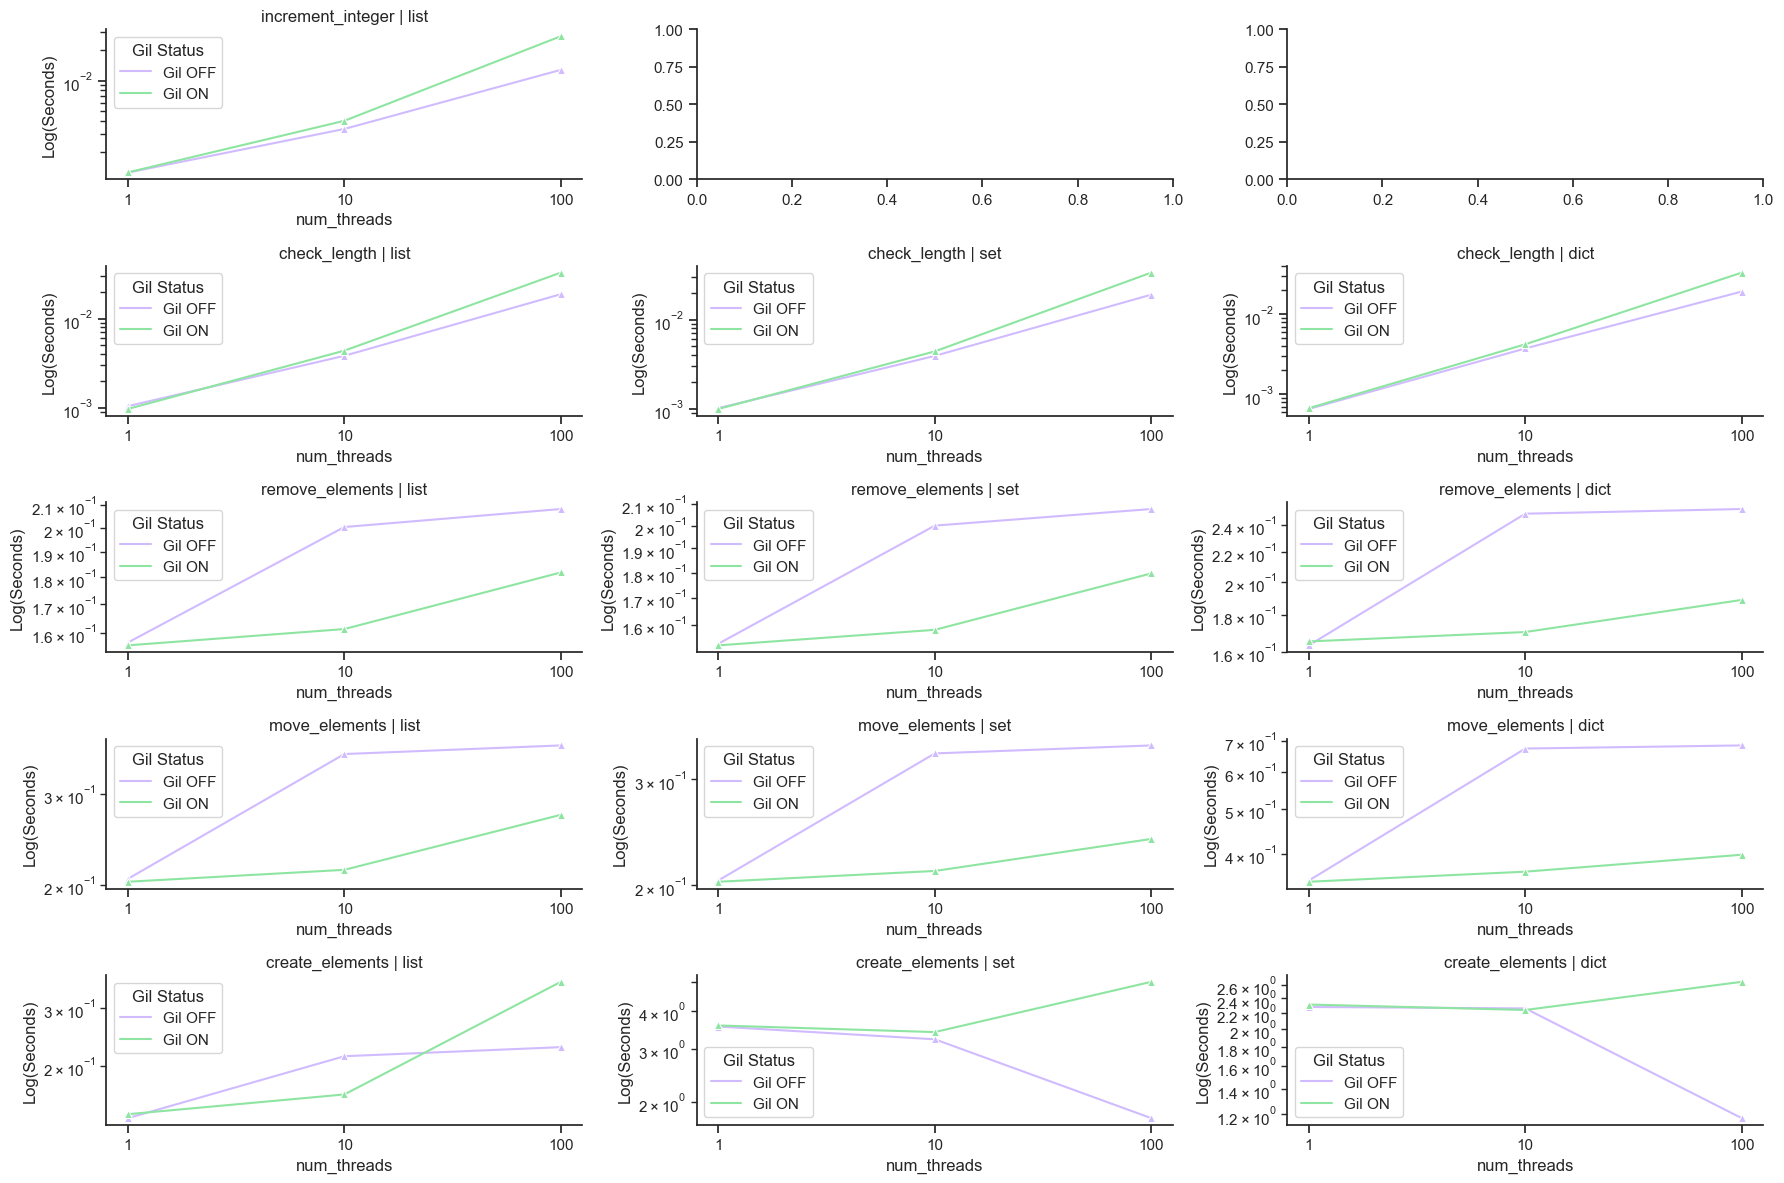

In [72]:
from itertools import zip_longest

fig, axes = plt.subplots(5, 3, figsize=(18, 12))

platform_df = df.query("platform == 'Linux'")

for subcommand, subcommand_axes in zip(platform_df.groupby('subcommand')['seconds'].mean().sort_values().index, axes):
    command_df = platform_df.loc[platform_df['subcommand'] == subcommand].copy()
    for ax, collection in zip_longest(subcommand_axes, command_df['collection'].unique(), fillvalue=None):
        sns.despine(ax=ax)
        if not collection:
            continue
        subdf = command_df.query(f"collection == '{collection}'").groupby(['gil', 'num_threads'])['seconds'].mean().reset_index()
        subdf['num_threads'] = subdf['num_threads'].astype(str)
        subdf['Gil Status'] = subdf['gil'].replace({0: 'Gil OFF', 1: 'Gil ON'})
        sns.lineplot(data=subdf, x="num_threads", y="seconds", hue="Gil Status", marker="^", palette=["m", "g"], ax=ax)
        ax.set_yscale("log")
        ax.set_ylabel("Log(Seconds)")

        ax.set_title(f"{subcommand} | {collection}")


plt.tight_layout()

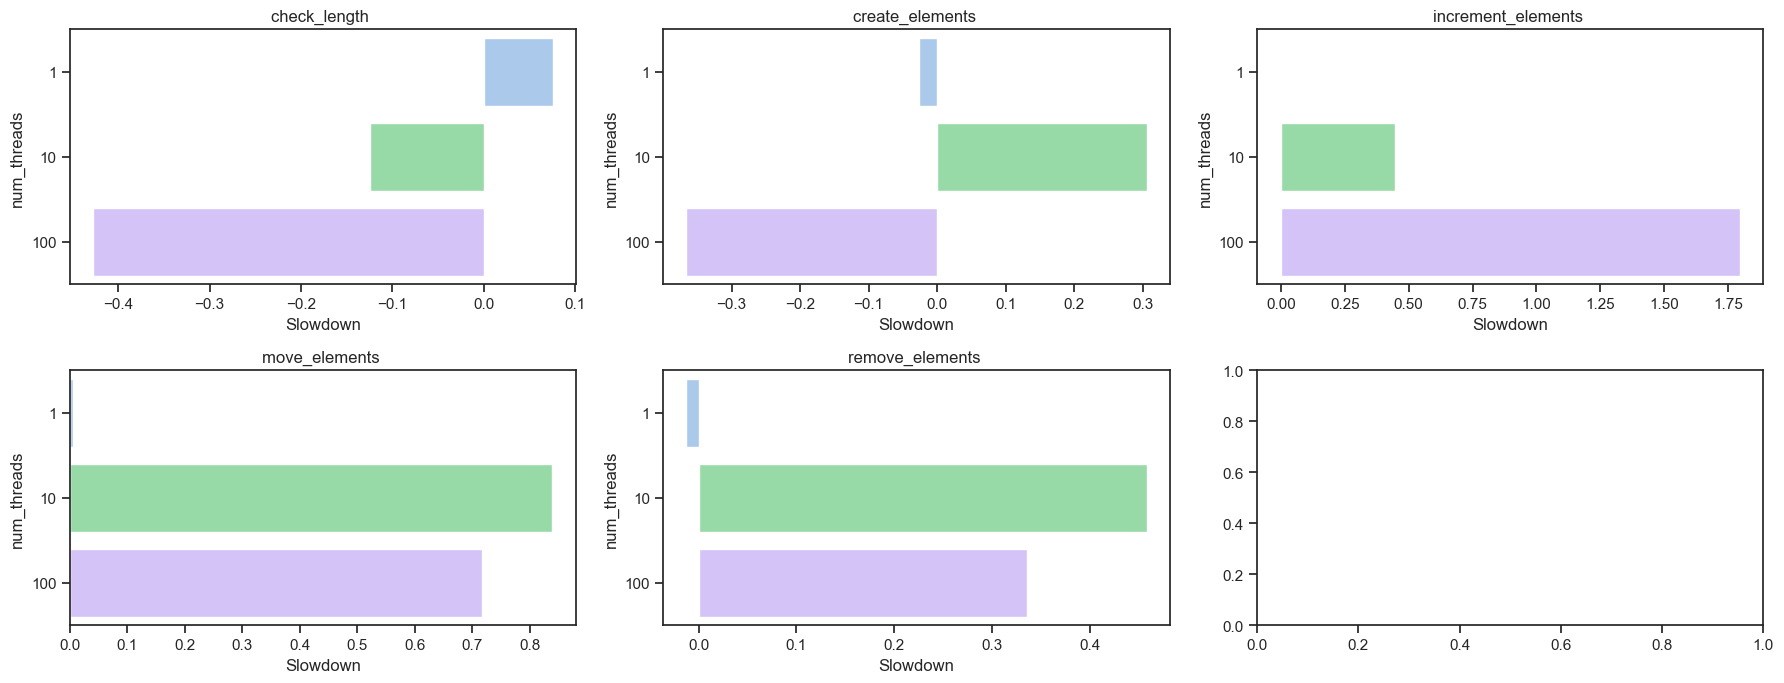

In [28]:
platform_df = df.query("platform == 'Linux'")
subdf = platform_df.groupby(['subcommand', 'collection', 'gil', 'num_threads'])['seconds'].mean().reset_index()
subdf = subdf.groupby(['subcommand', 'collection', 'num_threads']).apply(lambda rows: rows.groupby('gil')['seconds'].first().sort_index(ascending=False).pct_change().dropna().iloc[0]).to_frame().reset_index().rename(columns={0: 'Slowdown'})


subdf = subdf.groupby(['subcommand', 'collection'])['Slowdown'].max().reset_index()
filters = subdf.loc[subdf.groupby('subcommand')['Slowdown'].nlargest(1, keep='first').reset_index().query("Slowdown > 0")['level_1'].values, ['subcommand', 'collection']].values
filters

fig, axes = plt.subplots(2, 3, figsize=(18, 7))
for (subcommand, collection), ax in zip(filters, axes.flatten()):
    subdf = platform_df.query(f'subcommand == "{subcommand}" and collection == "{collection}"')
    subdf = subdf.groupby(['gil', 'num_threads'])['seconds'].mean().reset_index()
    subdf = subdf.groupby(['num_threads']).apply(lambda rows: rows.groupby('gil')['seconds'].first().sort_index(ascending=False).pct_change().dropna().iloc[0]).to_frame().reset_index().rename(columns={0: 'Slowdown'})

    sns.barplot(data=subdf, y="num_threads", x='Slowdown', palette=["b", "g", "m"], orient='h', ax=ax)
    ax.set_title(f"{subcommand} ")

plt.tight_layout()

### Comparison grid

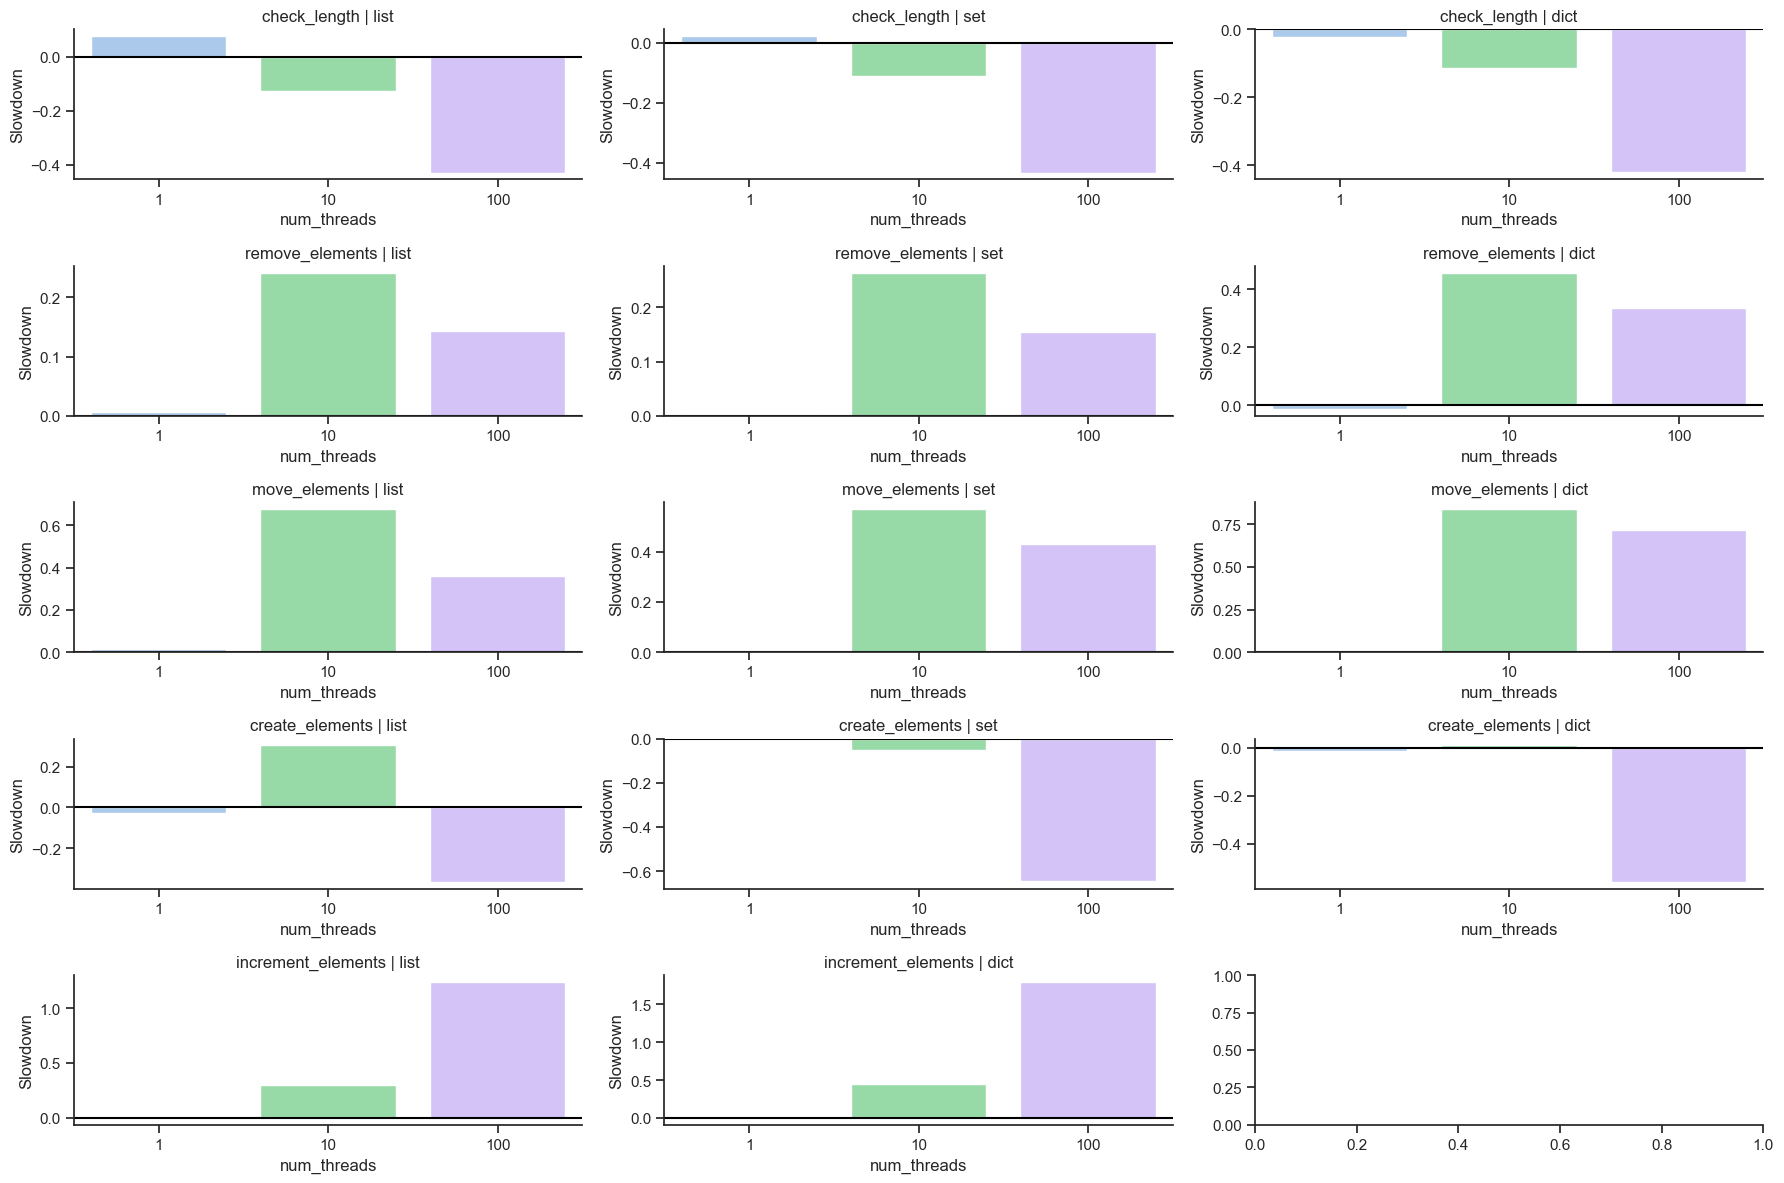

In [30]:
from itertools import zip_longest

platform_df = df.query("platform == 'Linux'")

fig, axes = plt.subplots(5, 3, figsize=(18, 12))

for subcommand, subcommand_axes in zip(platform_df.query("subcommand != 'increment_integer'").groupby('subcommand')['seconds'].mean().sort_values().index, axes):
    command_df = platform_df.loc[platform_df['subcommand'] == subcommand]
    for ax, collection in zip_longest(subcommand_axes, command_df['collection'].unique(), fillvalue=None):
        sns.despine(ax=ax)
        if not collection:
            continue
        subdf = command_df.query(f"collection == '{collection}'")
        if subcommand == 'increment_integer':
            subdf = subdf.query("num_iterations == 10000")
        subdf = subdf.groupby(['gil', 'num_threads'])['seconds'].mean().reset_index()
        subdf = subdf.groupby(['num_threads']).apply(lambda rows: rows.groupby('gil')['seconds'].first().sort_index(ascending=False).pct_change().dropna().iloc[0]).to_frame().reset_index().rename(columns={0: 'Slowdown'})
        subdf['num_threads'] = subdf['num_threads'].astype(str)
        sns.barplot(data=subdf, x="num_threads", y="Slowdown", palette=["b", "g", "m"], ax=ax)
        ax.axhline(0, color='black')
    
        ax.set_title(f"{subcommand} | {collection}")

plt.tight_layout()

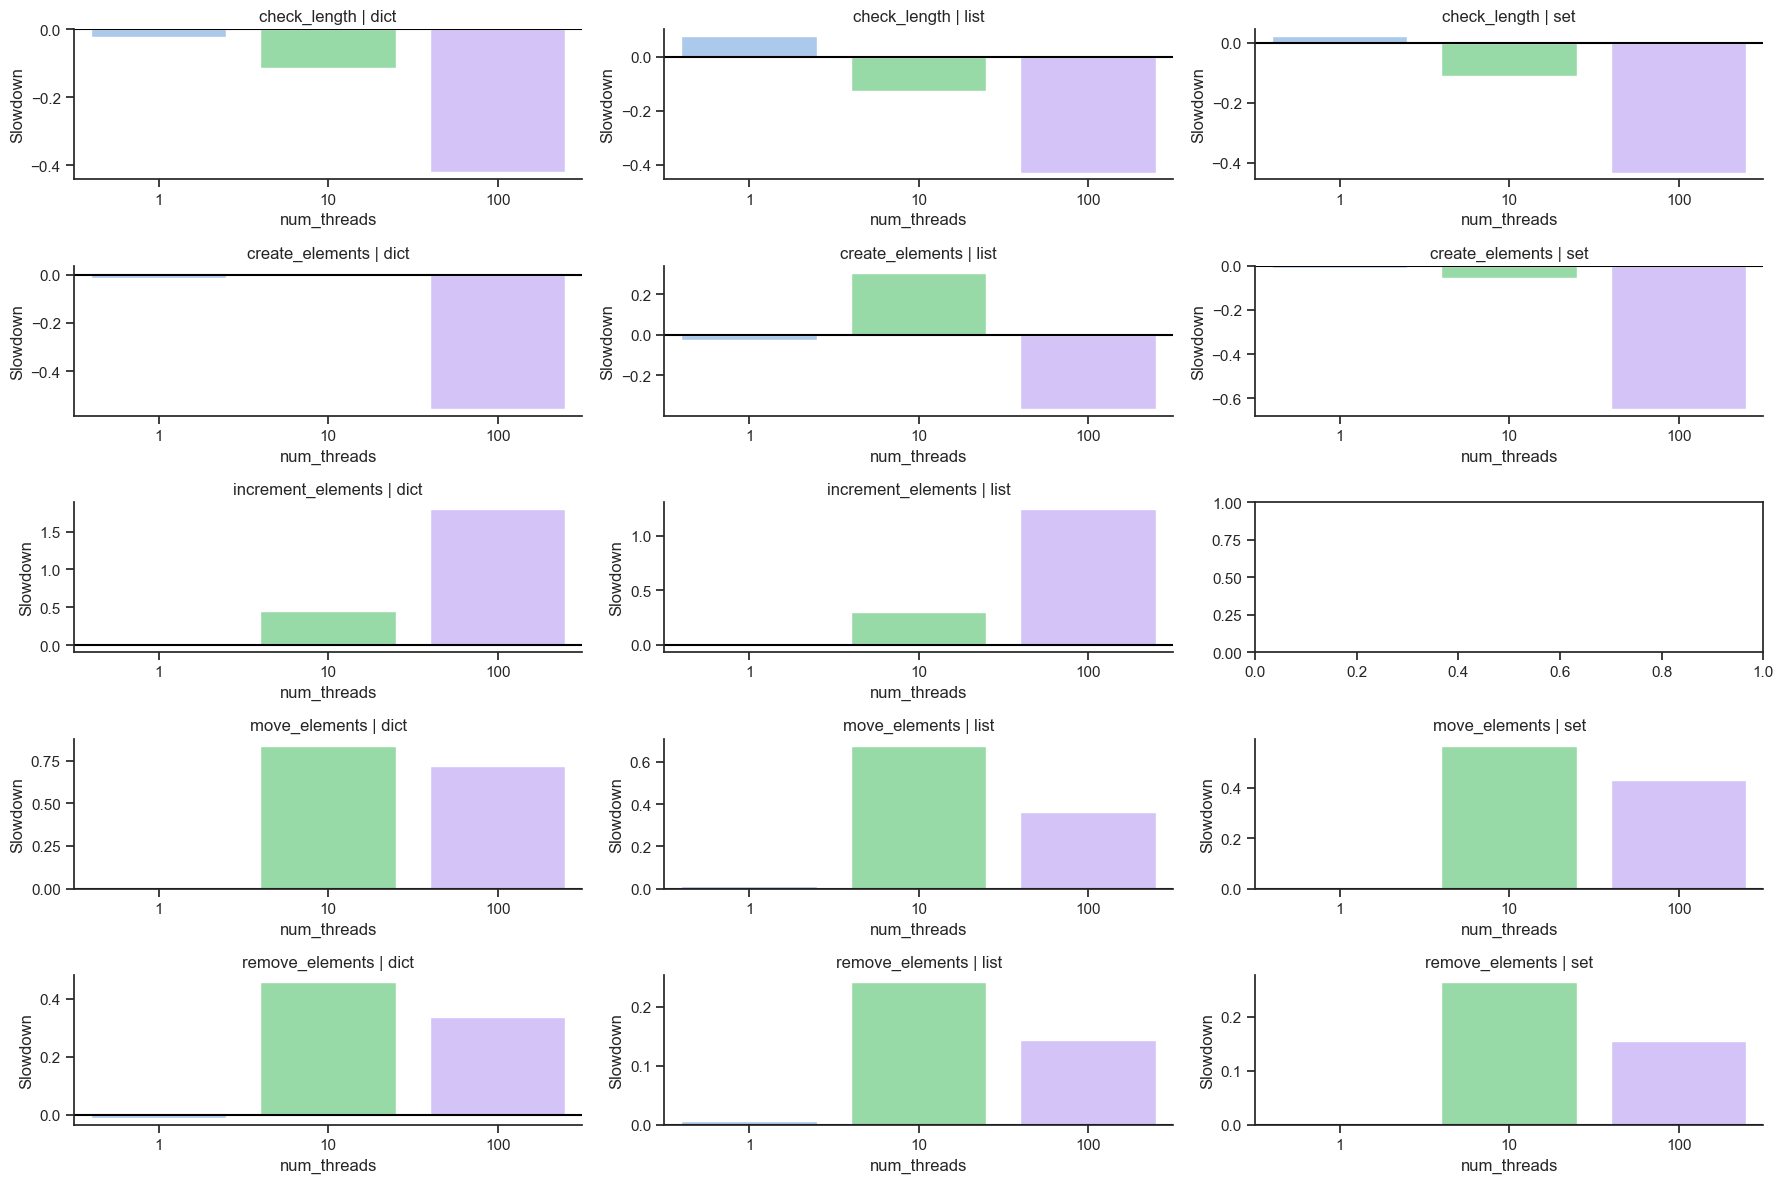

In [31]:
from itertools import zip_longest

fig, axes = plt.subplots(5, 3, figsize=(18, 12))

benchmarks = list(linux_slowdown_df.query("Benchmark != 'increment_integer'")['Benchmark'].unique())
for benchmark, benchmark_axes in zip(benchmarks, axes):
    bench_df = linux_slowdown_df.query(f"Benchmark == '{benchmark}'").copy()
    bench_df['num_threads'] = bench_df['num_threads'].astype(str)
    for ax, collection in zip_longest(benchmark_axes, bench_df['Collection'].unique(), fillvalue=None):
        bench_df.query(f"Collection == '{collection}'")
        if not collection:
            continue
        sns.despine(ax=ax)
        subdf = bench_df.query(f"Collection == '{collection}'")
        sns.barplot(data=subdf, x="num_threads", y="Slowdown", palette=["b", "g", "m"], ax=ax)
        ax.axhline(0, color='black')
    
        ax.set_title(f"{benchmark} | {collection}")

plt.tight_layout()

### Boxplots

In [33]:
df['threads'] = df["num_threads"].astype(str)
df['GIL'] = df['gil'].replace({0: "Disabled", 1: "Enabled"})

Linux:

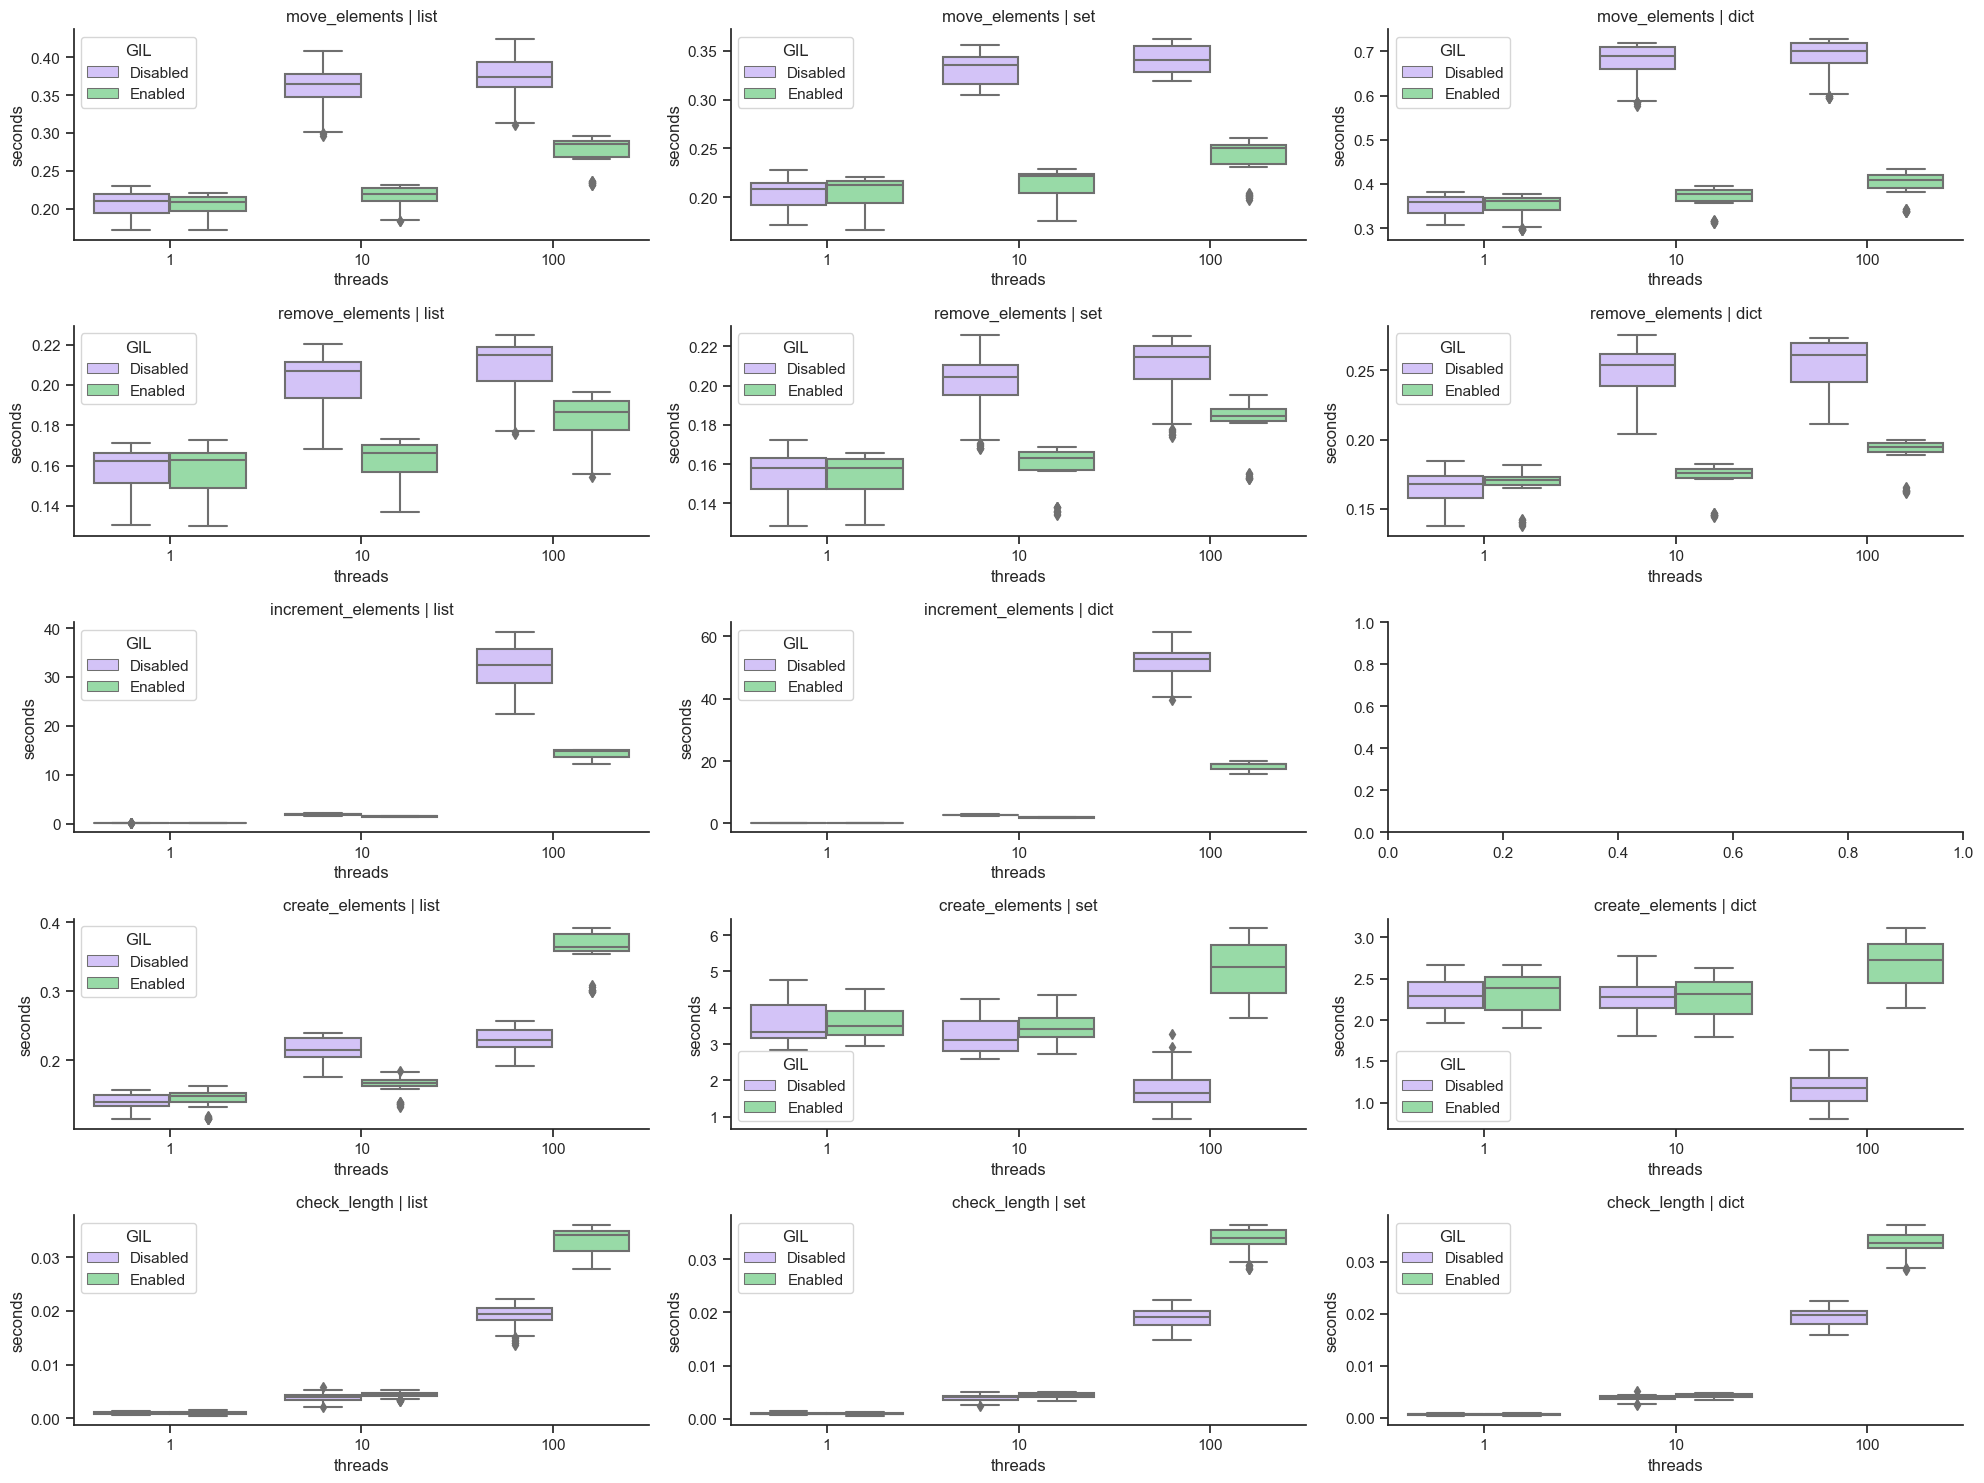

In [36]:
platform_df = df.query("platform == 'Linux'")
subcommands = set(platform_df['subcommand'].unique()) - {"increment_integer"}
rows, cols = len(subcommands), len(platform_df['collection'].unique())
rows, cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for subcommand, subcommand_axes in zip(subcommands, axes):
    subdf = platform_df.query(f"subcommand == '{subcommand}'")
    for collection, ax in zip_longest(subdf['collection'].unique(), subcommand_axes):
        sns.despine(ax=ax)
        if collection is None:
            continue
        
        sns.boxplot(subdf.query(f"collection == '{collection}'"), x='threads', y='seconds', hue='GIL', palette=["m", "g", "b"], ax=ax)
        ax.set_title(f"{subcommand} | {collection}")

plt.tight_layout()

Mac:

In [37]:
df['platform'].value_counts()

platform
Linux    4500
MacOS     960
Name: count, dtype: int64

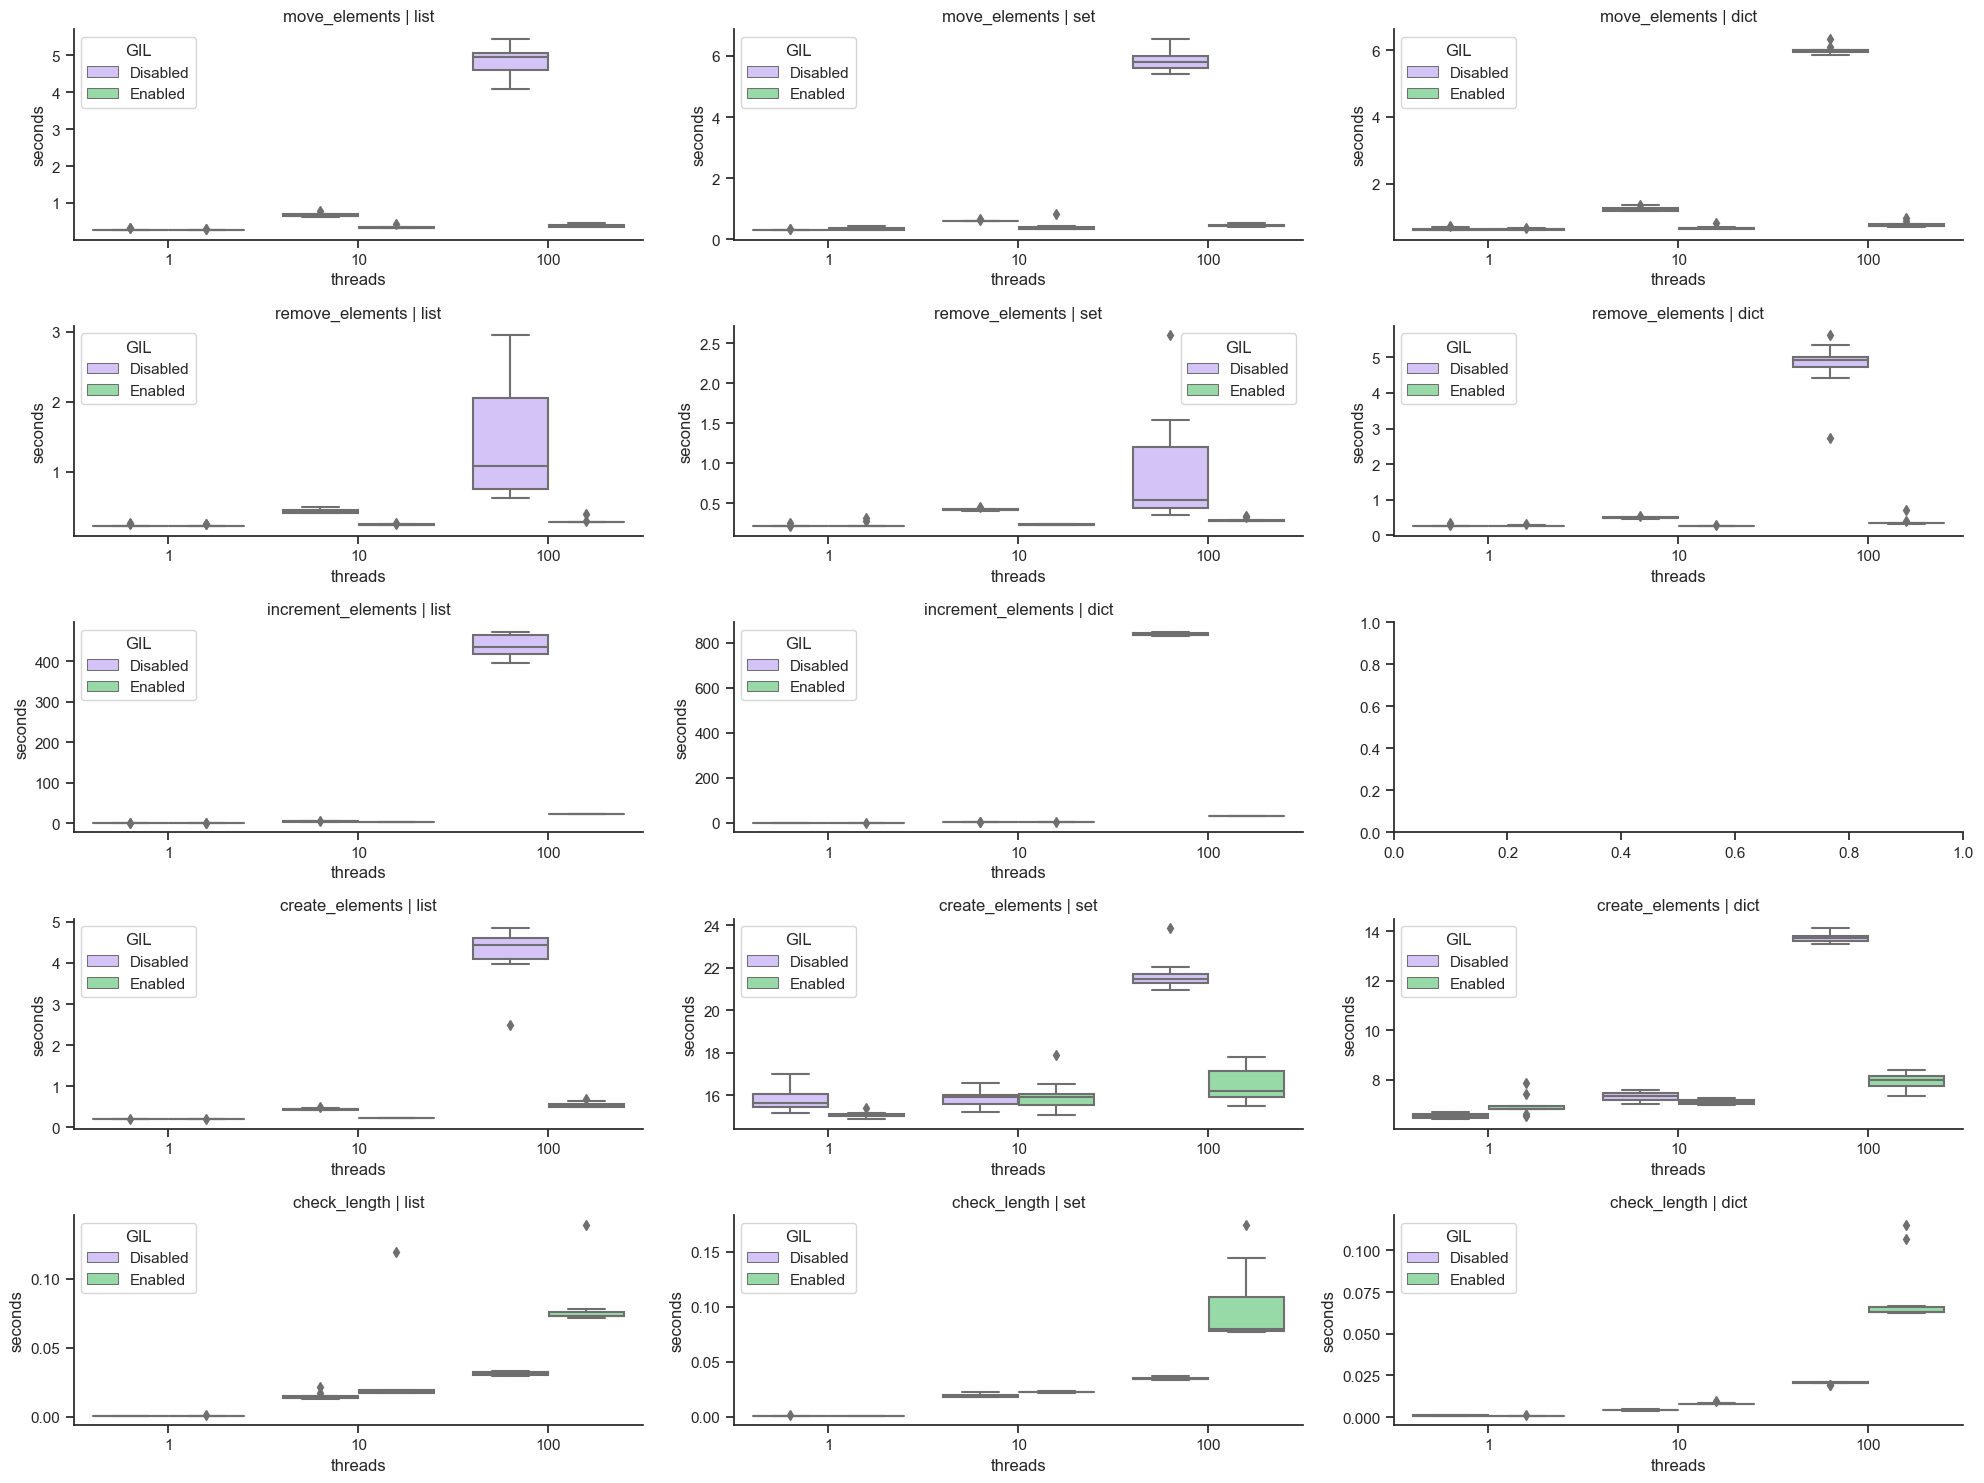

In [41]:
import numpy as np
platform_df = df.query("platform == 'MacOS'").copy()
subcommands = set(platform_df['subcommand'].unique()) - {"increment_integer"}
rows, cols = len(subcommands), len(platform_df['collection'].unique())
rows, cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for subcommand, subcommand_axes in zip(subcommands, axes):
    subdf = platform_df.query(f"subcommand == '{subcommand}'")
    for collection, ax in zip_longest(subdf['collection'].unique(), subcommand_axes):
        sns.despine(ax=ax)
        if collection is None:
            continue
        
        sns.boxplot(subdf.query(f"collection == '{collection}'"), x='threads', y='seconds', hue='GIL', palette=["m", "g", "b"], ax=ax)
        ax.set_title(f"{subcommand} | {collection}")

plt.tight_layout()

### Mac vs Linux

In [237]:
#platform_df = platform_df.query("gil == 0 and subcommand != 'increment_integer'")
platform_df = platform_df.query("subcommand != 'increment_integer'")

In [217]:
platform_df['threads'] = platform_df['num_threads'].astype(str)
platform_df['threads'].value_counts()

threads
1      840
10     840
100    840
Name: count, dtype: int64

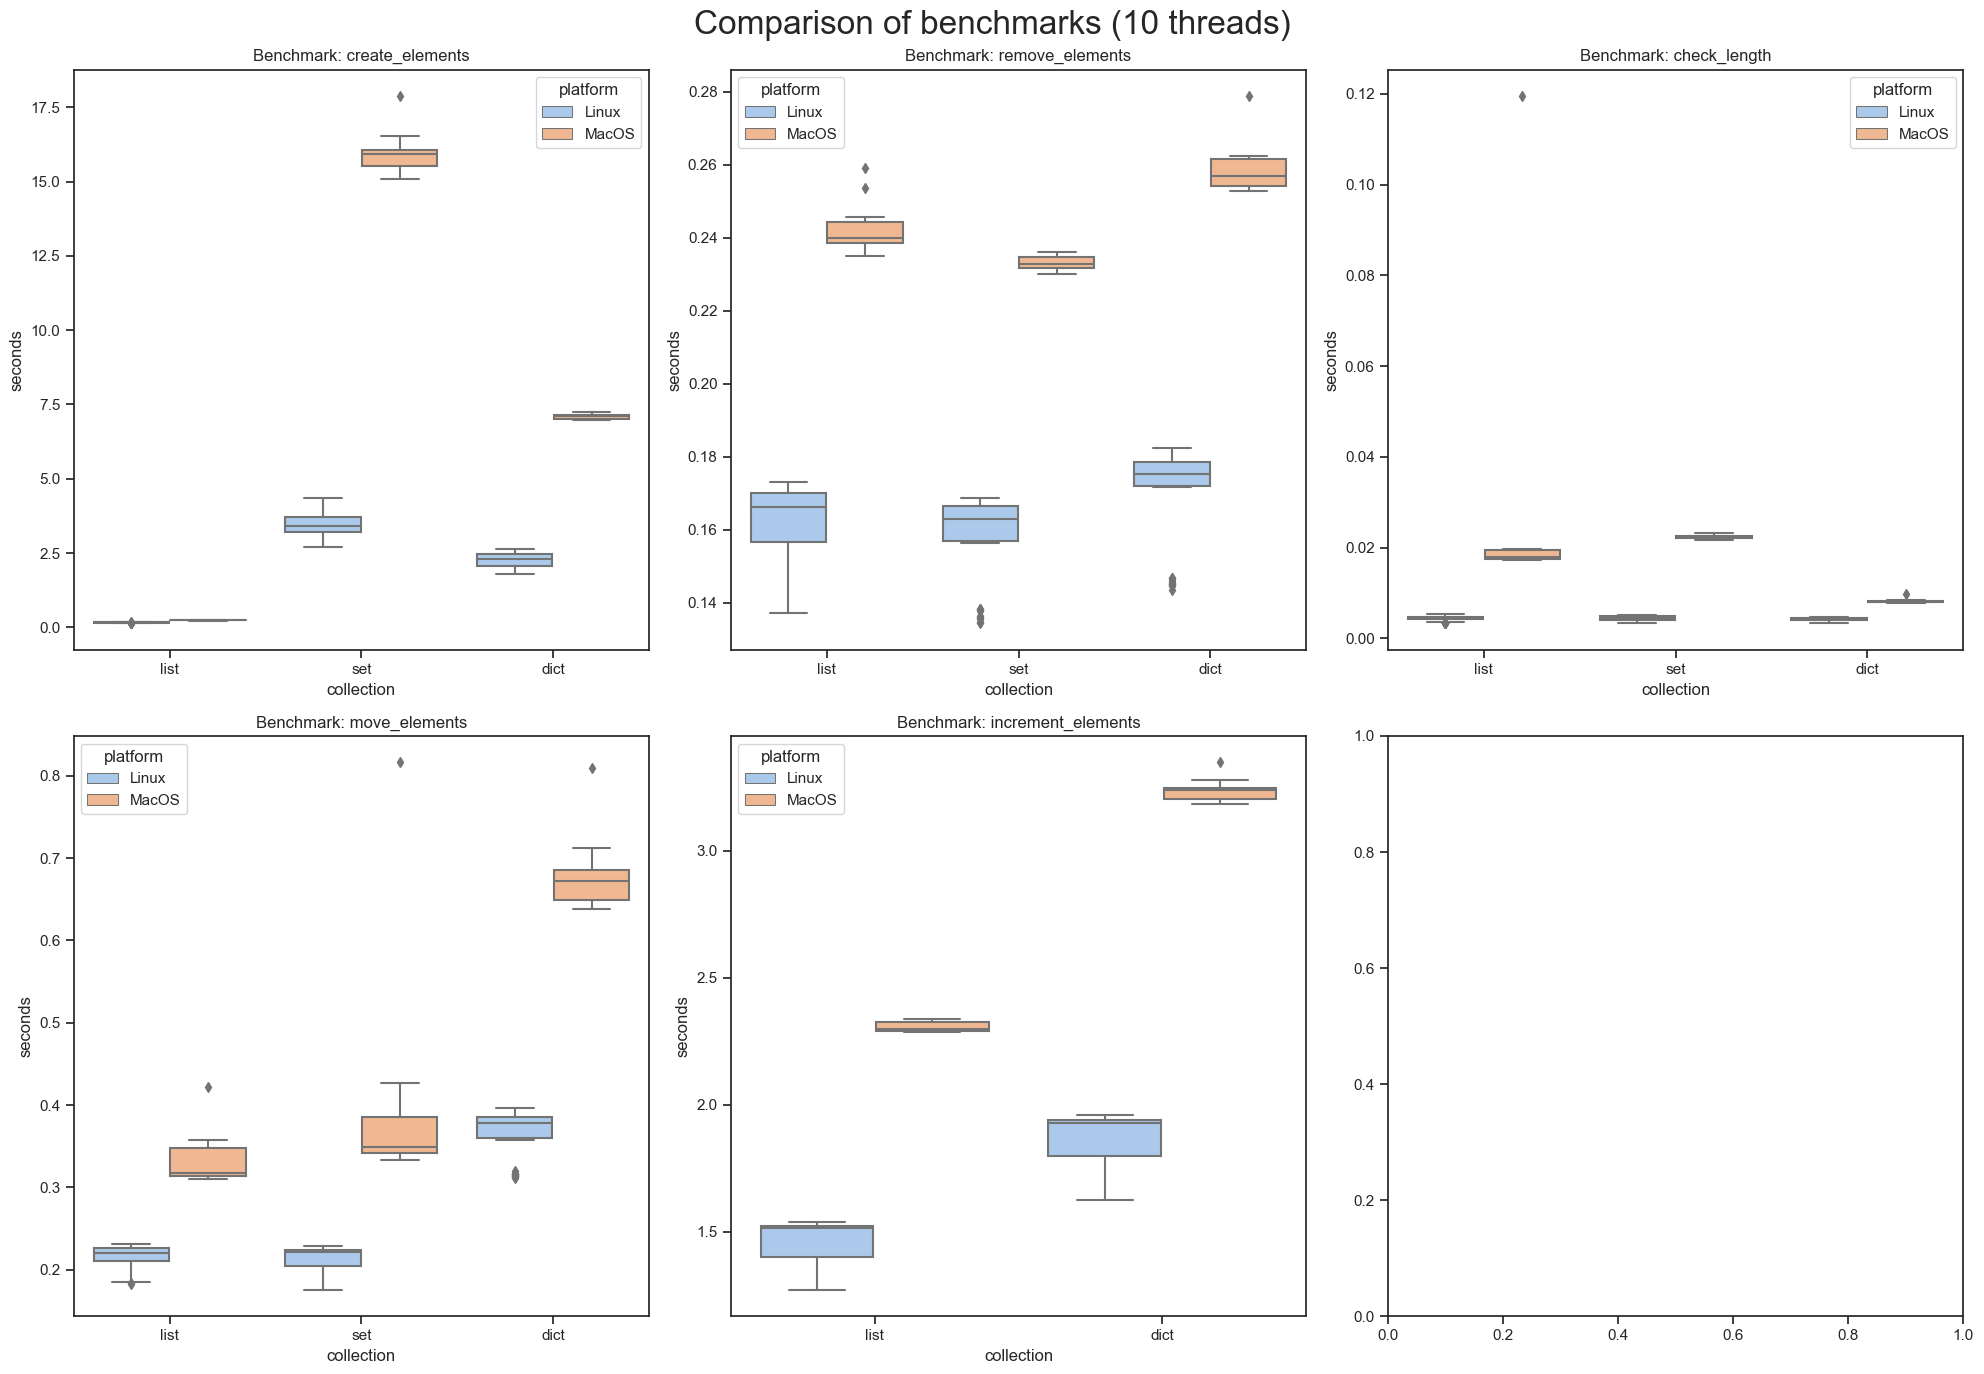

In [238]:
NUM_THREADS = 10
GIL = 1
subcommands = list(platform_df['subcommand'].unique())
collections = list(platform_df['collection'].unique())

fig, axes = plt.subplots(2, 3, figsize=(20, 14))

for subcommand, ax in zip_longest(subcommands, axes.ravel()):
    if not subcommand:
        continue
    sns.boxplot(platform_df.query(f"num_threads == {NUM_THREADS} and subcommand == '{subcommand}' and gil == {GIL}"), x='collection', y='seconds', hue="platform", ax=ax)
    ax.set_title(f"Benchmark: {subcommand}")

fig.suptitle(f"Comparison of benchmarks ({NUM_THREADS} threads)", fontsize=24)
plt.tight_layout()

In [70]:
NUM_THREADS = 10
GIL = 0
def fn(rows):
    platforms = dict(rows.groupby("platform")['seconds'].median())
    return platforms['MacOS'] / platforms['Linux']
groupped_df = df.query(f"num_threads == {NUM_THREADS} and gil == {GIL}").query("subcommand != 'increment_integer'").groupby(['subcommand', 'collection', ]).apply(fn).to_frame().rename(columns={0: 'Mac slowdown vs Linux'}).reset_index()
groupped_df

,subcommand,collection,Mac slowdown vs Linux
0,check_length,dict,1.073458
1,check_length,list,3.557648
2,check_length,set,4.526886
3,create_elements,dict,3.223014
4,create_elements,list,2.035222
5,create_elements,set,5.123832
6,increment_elements,dict,1.857111
7,increment_elements,list,1.963210
8,move_elements,dict,1.766070
9,move_elements,list,1.769231


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


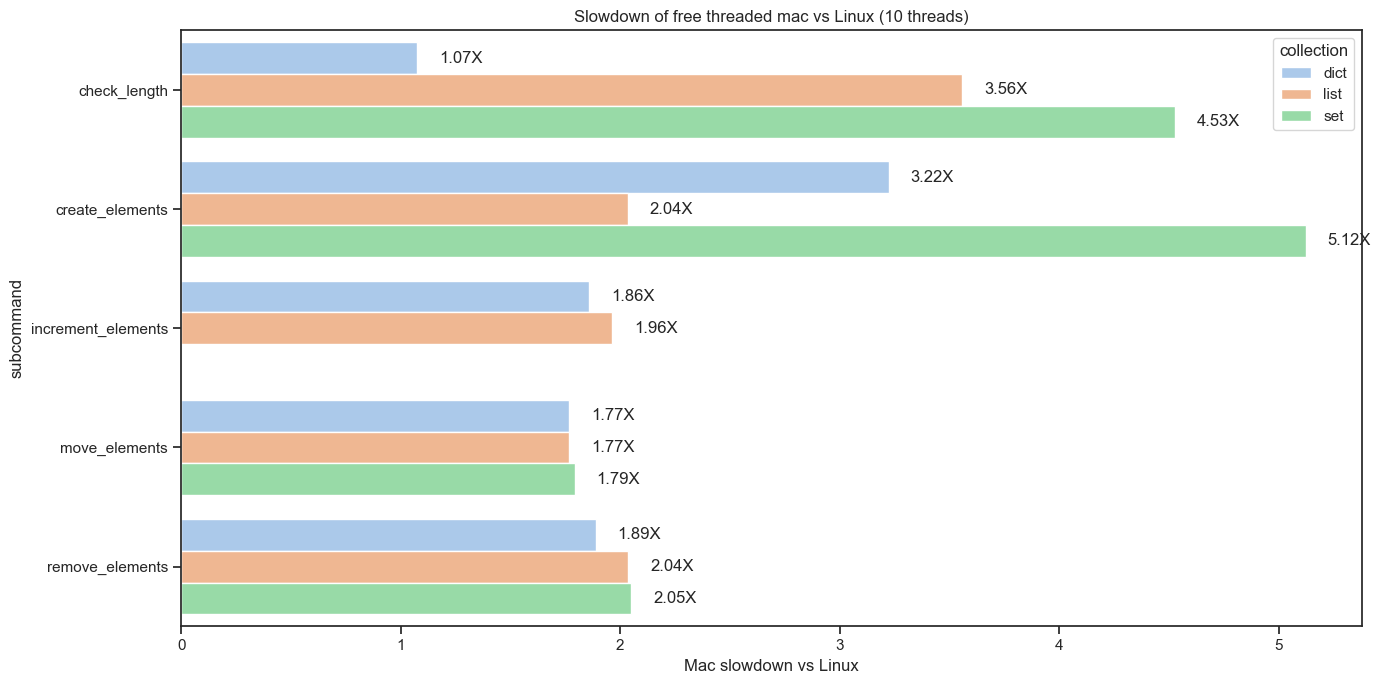

In [71]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(groupped_df, y='subcommand', x='Mac slowdown vs Linux', hue='collection', ax=ax, orient='h')
ax.set_title(f"Slowdown of free threaded mac vs Linux ({NUM_THREADS} threads)")

for bar in ax.patches:
    value = bar.get_width()
    position = bar.get_y() + bar.get_height() / 2

    ax.text(
        value + (0.1 if value > 0 else -0.1),  # Adjust text position slightly outside the bar
        position,
        f"{value:.2f}X",
        va='center',
        ha='left' if value > 0 else 'right'
    )
plt.tight_layout()